In [1]:
import pandas as pd
import numpy as np
import mlxtend
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from mlxtend.plotting import plot_decision_regions
from sklearn import svm 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.datasets import make_classification, make_circles

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles

In [2]:
seeds_train = pd.read_csv("seeds_train.csv", names=["feature_1", "feature_2", "target"]) 
seeds_test = pd.read_csv("seeds_test.csv", names=["feature_1", "feature_2", "target"])
target_names = ['Kama','Rosa','Canadian'] 

In [3]:
seeds_train.head()

,feature_1,feature_2,target
0,14.84,2.221,1
1,14.09,2.699,1
2,13.94,2.259,1
3,14.99,1.355,1
4,14.49,3.586,1


In [4]:
seeds_train_two_class = seeds_train[seeds_train["target"] != 1]
seeds_test_two_class = seeds_test[seeds_test["target"] != 1] 

In [5]:
seeds_train_two_class.sample(frac=1).head()

,feature_1,feature_2,target
89,16.61,6.682,2
66,16.74,1.472,2
96,15.38,4.286,2
164,13.41,8.456,3
84,16.17,2.843,2


In [6]:
def Plot_decision_regions(data, Labels, model, model_name):
    plot_decision_regions(data, Labels, clf=model, legend=1)
    # Adding axes annotations
    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.title(f'{model_name} on Seeds')
    plt.show()

In [10]:
'''The following two functions are adapted from the course tutorials.'''

def plotData(X, y, cls, class_names, title=''):
    colors = ['r', 'b', 'g']
    markers = ['o', '*', '+']
    
    for class_index in range(len(cls)):
        plt.scatter(X[y == cls[class_index],0], X[y == cls[class_index],1], 
                    c=colors[class_index - 1], marker = markers[class_index - 1], 
                    label=class_names[cls[class_index]-1])
        plt.title(title)
        plt.legend()

def plotRegions(models, X, weights=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    XX, YY = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                         np.arange(y_min, y_max, 0.01))
    
    z = predict_OVR(models, np.c_[XX.ravel(), YY.ravel()], weights)
    ZZ = z.reshape(XX.shape)
    plt.contourf(XX, YY, ZZ, alpha=0.2)

In [7]:
def prepare_data(train_df, test_df):
    #shuffle the two dataframes
    train_df = train_df.sample(frac = 1)
    test_df = test_df.sample(frac = 1)
    
    #split into features and labels
    X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = prepare_data(seeds_train_two_class, seeds_test_two_class)

print(f"X_train shape: {X_train.shape} y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} y_test shape: {y_test.shape}")

X_train shape: (111, 2) y_train shape: (111,)
X_test shape: (29, 2) y_test shape: (29,)


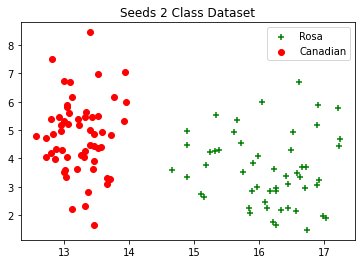

In [11]:
plotData(X_train.to_numpy(), y_train.to_numpy(), [2, 3], target_names, "Seeds 2 Class Dataset")

Accuracy of model: 100.00%

Confusion Matrix:

[[17  0]
 [ 0 12]]


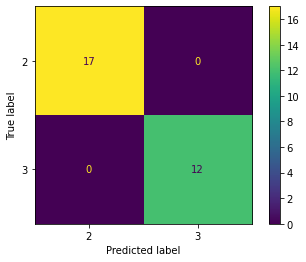

In [12]:
svm_model = svm.SVC(kernel='linear', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

svm_acc = svm_model.score(X_test, y_test ) * 100
print('Accuracy of model: {:.2f}%'.format(svm_acc))
print('\nConfusion Matrix:\n')
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(svm_model, X_test, y_test)

Accuracy of model: 100.00%

Confusion Matrix:

[[17  0]
 [ 0 12]]


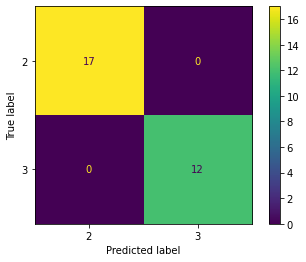

In [13]:
preceptron_model = Perceptron(n_iter_no_change=2000, max_iter=4500)
preceptron_model.fit(X_train, y_train)
y_pred = preceptron_model.predict(X_test)

preceptron_acc = preceptron_model.score(X_test, y_test) * 100
print('Accuracy of model: {:.2f}%'.format(preceptron_acc))
print('\nConfusion Matrix:\n')
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(preceptron_model, X_test, y_test)

In [14]:
def binarize_series(data, values):
    binarized_values = []
    for v in values:
        bin_col = data.apply(lambda x: 1 if x == v else -1)
        binarized_values.append(bin_col)
    return binarized_values

In [15]:
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

def train_OVR_model(model, X_train, y_train_binarized, optimize_params=False, params={}):
    models = []
    for y_train in y_train_binarized:
        clf = clone(model)
        if(optimize_params):
            clf = GridSearchCV(clf, params)
            clf.fit(X_train, y_train)
            models.append(clf.best_estimator_)
        else:
            clf.fit(X_train, y_train)
            models.append(clf)
    return models

def test_OVR_models(models, X_test, y_test_binarized):
    preds = []
    accs = []
    for i, model in enumerate(models):
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test_binarized[i]) * 100
        preds.append(y_pred)
        accs.append(accuracy)
    return preds, accs

def plot_OVR_decisions(models, X_test, y_test_binarized, y_pred, accuracies):
    for i, model in enumerate(models):
        print(f"Accuracy = {accuracies[i]}")
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(y_test_binarized[i], y_pred[i]))
        Plot_decision_regions(X_test.to_numpy(), y_test_binarized[i].to_numpy(),
                              model, f"{model.__class__.__name__} - {i}")
    
def predict_OVR(models, X_test, weights=None, n_classes=3):
    confidences = np.empty(shape=(n_classes, X_test.shape[0]))
    for i, model in enumerate(models):
        confidences[i] = model.decision_function(X_test)
        if(weights is not None):
            confidences[i] = confidences[i] * weights[i]
    preds = np.argmax(confidences, axis=0) + 1
    return preds

In [16]:
X_train, X_test, y_train, y_test = prepare_data(seeds_train, seeds_test)

y_train_binarized = binarize_series(y_train, sorted(y_train.unique()))
y_test_binarized = binarize_series(y_test, sorted(y_train.unique()))

In [33]:
param_grid = {'max_iter':np.linspace(100, 2000, 20), 'eta0': [0.0001, 0.001, 0.01, 1.0],
              'n_iter_no_change': [100, 200, 500], 'penalty':['l2', None]}
percep = Perceptron()
percep_models = train_OVR_model(percep, X_train, y_train_binarized, 
                                optimize_params=True, params=param_grid)

c:\users\amrsh\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\amrsh\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\amrsh\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\amrsh\appdata\local\programs\python\python39\lib\site-packages\s

In [34]:
percep_models

[Perceptron(eta0=0.01, max_iter=500.0, n_iter_no_change=200, penalty='l2'),
 Perceptron(eta0=0.01, max_iter=600.0, n_iter_no_change=200, penalty='l2'),
 Perceptron(eta0=0.0001, max_iter=600.0, n_iter_no_change=500, penalty='l2')]

Accuracy = 78.57142857142857

Confusion Matrix:

[[21  8]
 [ 1 12]]


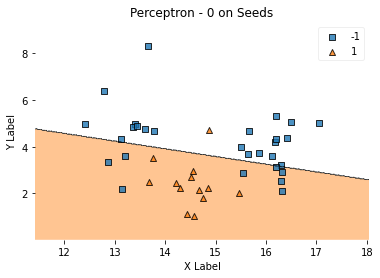

Accuracy = 100.0

Confusion Matrix:

[[25  0]
 [ 0 17]]


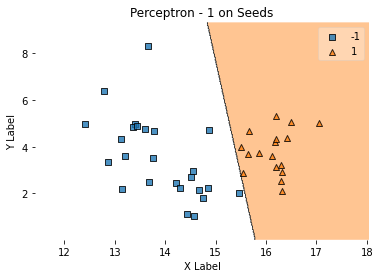

Accuracy = 95.23809523809523

Confusion Matrix:

[[30  0]
 [ 2 10]]


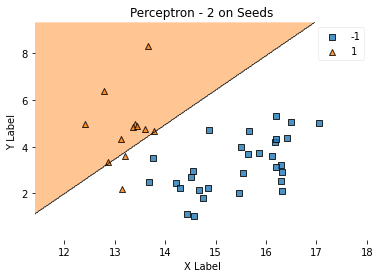

In [35]:
y_pred, accs = test_OVR_models(percep_models, X_test, y_test_binarized)
plot_OVR_decisions(percep_models, X_test, y_test_binarized, y_pred, accs)

In [36]:
svm_model = svm.SVC(probability=True, gamma='auto')
svm_models = train_OVR_model(svm_model, X_train, y_train_binarized)

Accuracy = 92.85714285714286

Confusion Matrix:

[[28  1]
 [ 2 11]]


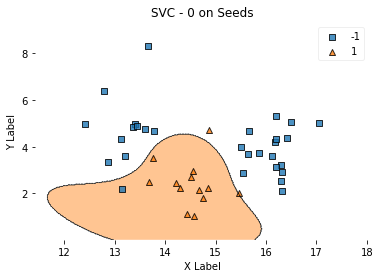

Accuracy = 97.61904761904762

Confusion Matrix:

[[24  1]
 [ 0 17]]


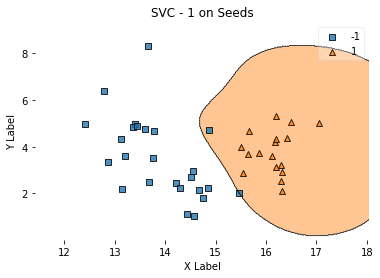

Accuracy = 97.61904761904762

Confusion Matrix:

[[30  0]
 [ 1 11]]


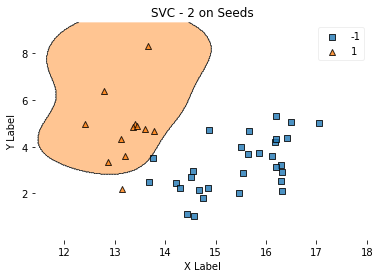

In [37]:
y_pred, accs = test_OVR_models(svm_models, X_test, y_test_binarized)
plot_OVR_decisions(svm_models, X_test, y_test_binarized, y_pred, accs)

# Aggregate predictions using argmax

In [38]:
svm_agg_preds = predict_OVR(svm_models, X_test)
acc = accuracy_score(y_test, svm_agg_preds)
print(f"SVM argmax aggregated predictions acc = {acc}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_agg_preds))

SVM argmax aggregated predictions acc = 0.9285714285714286

Confusion Matrix:
 [[11  2  0]
 [ 0 17  0]
 [ 1  0 11]]


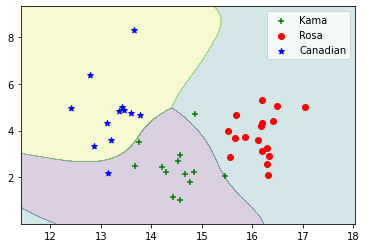

In [39]:
plotRegions(svm_models, X_test.to_numpy())
plotData(X_test.to_numpy(), y_test, [1, 2, 3], target_names)

In [40]:
perceptron_agg_preds = predict_OVR(percep_models, X_test)
acc = accuracy_score(y_test, perceptron_agg_preds)

print(f"Perceptron argmax aggregated predictions acc = {acc}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, perceptron_agg_preds))

Perceptron argmax aggregated predictions acc = 0.8571428571428571

Confusion Matrix:
 [[12  0  1]
 [ 2 15  0]
 [ 3  0  9]]


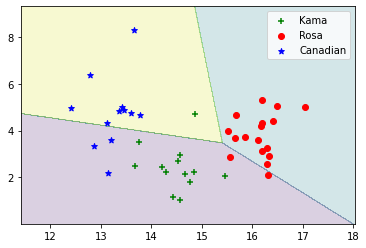

In [41]:
plotRegions(percep_models, X_test.to_numpy())
plotData(X_test.to_numpy(), y_test, [1, 2, 3], target_names)

# Aggregate predictions using weights

In [42]:
import itertools

In [43]:
def tune_weights(models, X_test, y_test, w_min, w_max, n_weights):
    weights = np.linspace((w_min, w_min, w_min), (w_max, w_max, w_max), n_weights, axis=1)
    weight_combs = list(itertools.product(*[weights[0], weights[1], weights[2]]))
    
    max_acc = 0
    best_weights = []

    for w1, w2, w3 in weight_combs:
        preds = predict_OVR(models, X_test, weights=[w1, w2, w3], n_classes=3)
        acc = accuracy_score(y_test, preds)
        if(acc > max_acc):
            max_acc = acc
            best_weights = [w1, w2, w3]
    return best_weights, max_acc

In [44]:
percep_weights, percep_acc = tune_weights(percep_models, X_test, y_test, 0.1, 1, 10)
best_preds = predict_OVR(percep_models, X_test, weights=percep_weights, n_classes=3)
print(f"Perceptron weighted predictions acc = {percep_acc}")
print(f"Best weights = {percep_weights}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, best_preds))

Perceptron weighted predictions acc = 0.9047619047619048
Best weights = [0.1, 0.9, 0.1]

Confusion Matrix:
 [[12  0  1]
 [ 0 17  0]
 [ 3  0  9]]


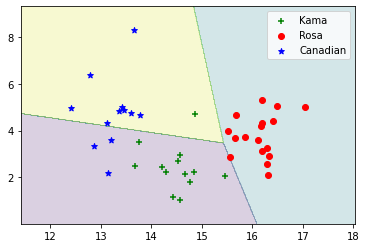

In [45]:
plotRegions(percep_models, X_test.to_numpy(), percep_weights)
plotData(X_test.to_numpy(), y_test, [1, 2, 3], target_names)

In [46]:
svm_weights, svm_acc = tune_weights(svm_models, X_test, y_test, 0.1, 1, 25)
best_preds = predict_OVR(svm_models, X_test, weights=svm_weights, n_classes=3)
print(f"Perceptron weighted predictions acc = {svm_acc}")
print(f"Best weights = {svm_weights}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, best_preds))

Perceptron weighted predictions acc = 0.9285714285714286
Best weights = [0.1, 0.1, 0.1]

Confusion Matrix:
 [[11  2  0]
 [ 0 17  0]
 [ 1  0 11]]


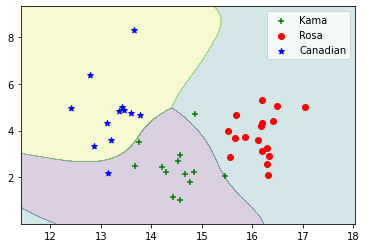

In [47]:
plotRegions(svm_models, X_test.to_numpy(), svm_weights)
plotData(X_test.to_numpy(), y_test, [1, 2, 3], target_names)

# Dynamic aggregation using Naive Bayes
Reference: Hong, J., Min, J., Cho, U., & Cho, S. (2008). Fingerprint classification using one-vs-all support vector machines dynamically ordered with naive Bayes classifiers. Pattern Recognit., 41, 662-671.

In [48]:
from sklearn.naive_bayes import GaussianNB

In [49]:
def aggregate_NB(models, X_train, X_test, y_train, y_test):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    class_probs = nb_classifier.predict_proba(X_test)
    sorted_idxs = np.argsort(class_probs)
    
    n_examples = sorted_idxs.shape[0]
    n_classifiers = sorted_idxs.shape[1]
    agg_preds = []

    for i in range(n_examples):
        for j in range(n_classifiers-1, -1, -1):
            classifier_idx = sorted_idxs[i, j]
            classifier = models[classifier_idx]
            pred = classifier.decision_function(X_test.iloc[i,:].to_numpy().reshape(1, -1))
            if(pred > 0): # positive label encountered
                agg_preds.append(classifier_idx + 1)
                break
            elif(j == 0): # no positive labels, assing NB most probable class
                agg_preds.append(sorted_idxs[i, j] + 1)
    return agg_preds

In [50]:
percep_agg_preds = aggregate_NB(percep_models, X_train, X_test, y_train, y_test)
acc = accuracy_score(y_test, percep_agg_preds)
print("Accuracy = ", acc)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, percep_agg_preds))

Accuracy =  0.9285714285714286

Confusion Matrix:
 [[12  0  1]
 [ 0 17  0]
 [ 2  0 10]]


In [51]:
svm_agg_preds = aggregate_NB(svm_models, X_train, X_test, y_train, y_test)
acc = accuracy_score(y_test, svm_agg_preds)

print("Accuracy = ", acc)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_agg_preds))

Accuracy =  0.9285714285714286

Confusion Matrix:
 [[11  1  1]
 [ 0 17  0]
 [ 1  0 11]]
